In [1]:
import os, sys
import pathlib
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_io as tfio
import tensorflow_addons as tfa
from tensorflow.keras import models, Model
from tensorflow.image import ResizeMethod
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Normalization
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Running on Python {sys.version}, Tensorflow {tf.__version__}.')

Running on Python 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)], Tensorflow 2.5.0.


In [2]:
# Data loading
seed = 69
AUTOTUNE = tf.data.AUTOTUNE
tf.random.set_seed(seed)
np.random.seed(seed)
sample_rate = 16000

data_dir = pathlib.Path('s1_release')
labels = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', labels)

# load given train set
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/labels[0]))))
print('Example file tensor:', filenames[0])

train_files = filenames[:round(num_samples*0.8)]  # first 80%
val_files = filenames[round(num_samples*0.8):]  # last 20%

print('Training set size', len(train_files))
print('Validation set size', len(val_files))

# load given test set
data_dir = pathlib.Path('s1_test_release')
test_files = tf.io.gfile.glob(str(data_dir) + '/*')  # provided
print('Test set size', len(test_files))

Commands: ['bird' 'eight' 'falcon' 'five' 'four' 'nine' 'one' 'seven' 'six' 'snake'
 'three' 'two' 'zero']
Number of total examples: 3250
Number of examples per label: 250
Example file tensor: tf.Tensor(b's1_release\\bird\\train_bird_8434.wav', shape=(), dtype=string)
Training set size 2600
Validation set size 650
Test set size 649


<AudioIOTensor: shape=[16000     1], dtype=<dtype: 'int16'>, rate=16000>
tf.Tensor(
[-0.00054932 -0.00030518 -0.0007019  ...  0.18273926  0.0295105
 -0.17550659], shape=(16000,), dtype=float32)


tf.Tensor([  648 15494], shape=(2,), dtype=int64)
tf.Tensor(648, shape=(), dtype=int64) tf.Tensor(15494, shape=(), dtype=int64)


spectrogram shape: (100, 257)
log spectrogram shape: (100, 250)
MFCC Shape: (100, 250)
tf.Tensor(
[[-3.9386826e+02 -3.5071129e+01 -1.2990907e+02 ... -1.0360402e+00
  -1.1471616e+00 -3.7082419e-01]
 [-3.2859567e+02 -4.5811146e+01 -1.4191969e+02 ... -2.4963324e+00
  -3.2122660e+00  3.7660253e+00]
 [-3.2000122e+02 -2.5507204e+01 -1.3746262e+02 ... -1.0454949e+00
  -4.1252673e-01 -1.4272498e+00]
 ...
 [-1.1162520e+03  2.8890970e+00 -7.1469612e+00 ...  1.4092933e-01
   8.9817017e-02 -1.8183550e-02]
 [-1.1162520e+03  2.8890970e+00 -7.1469612e+00 ...  1.4092933e-01
   8.9817017e-02 -1.8183550e-02]
 [-1.1162520e+03  2.8890970e+00 -7.1469612e+00 ...  1.4092933e-01
   8.9817017e-02 -1.8183550e-02]], shape=(100, 250), dtype=float32)
tf.Tensor(
[[6.3712299e-03 1.0785350e-02 6.1827251e-03 ... 1.3335455e-03
  1.3553494e-03 1.3546348e-03]
 [1.4007390e-03 3.8222820e-03 1.0510262e-02 ... 6.7676396e-05
  6.0010101e-05 4.8279762e-05]
 [2.0268306e-02 2.2411751e-02 2.7998960e-02 ... 8.1095443e-04
  7.69976

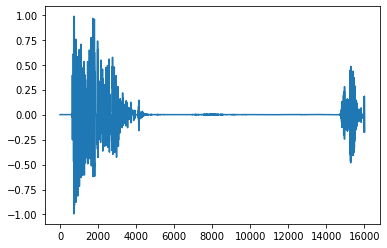

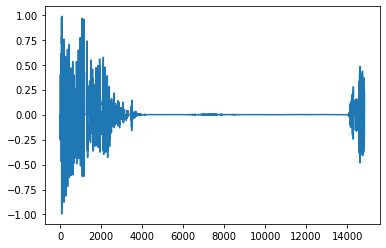

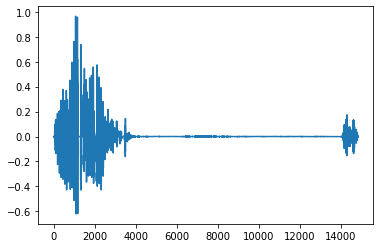

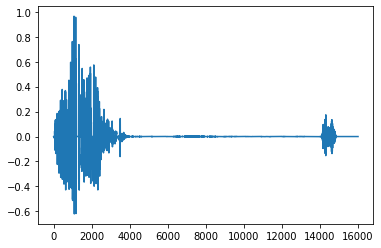

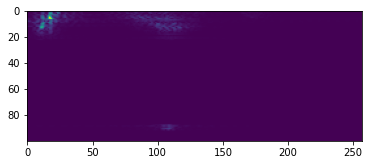

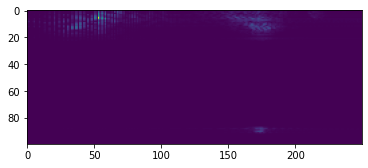

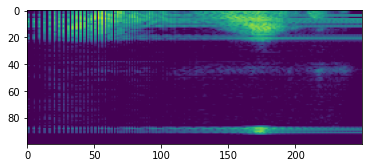

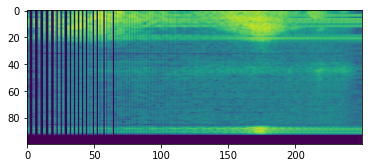

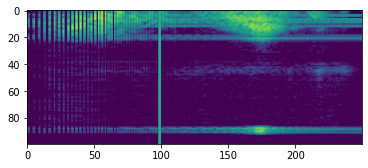

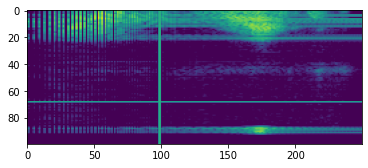

In [3]:
# Preprocessing
# Read file into AudioIOTensor, need to specify dtype as running it inside a tf.data function without eager execution
audio = tfio.audio.AudioIOTensor('s1_release/eight/train_eight_3153.wav', dtype=tf.int16)
audio_tensor = tf.cast(tf.squeeze(audio.to_tensor()), tf.float32) / 32768.0
print(audio)
print(audio_tensor)
display.display(display.Audio(audio_tensor, rate=sample_rate))

plt.figure()
plt.plot(audio_tensor.numpy())

# Trim noise (TODO: try with different gate, default 0.1)
position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.2)  # epsilon = noise gate (how loud between 0 to 1)
print(position)
start = position[0]
stop = position[1]
print(start, stop)
trimmed_audio_tensor = audio_tensor[start:stop]
display.display(display.Audio(trimmed_audio_tensor, rate=sample_rate))
plt.figure()
plt.plot(trimmed_audio_tensor.numpy())

# Fade in fade out (TODO: to try)
faded_audio_tensor = tfio.audio.fade(trimmed_audio_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")
display.display(display.Audio(faded_audio_tensor, rate=sample_rate))
plt.figure()
plt.plot(faded_audio_tensor.numpy())

# zero pad to 16000
zero_padding = tf.zeros([sample_rate] - tf.shape(faded_audio_tensor), dtype=tf.float32)
faded_audio_tensor = tf.cast(faded_audio_tensor, tf.float32)
padded_audio_tensor = tf.concat([faded_audio_tensor, zero_padding], 0)
display.display(display.Audio(padded_audio_tensor, rate=sample_rate))
plt.figure()
plt.plot(padded_audio_tensor.numpy())

# Convert to spectrogram and merge into 3 channels
# first line is from paper, 2nd is halved
# stft_params = [{'nfft': 1024, 'window': 800, 'stride': 320}, {'nfft': 2048, 'window': 1600, 'stride': 800}, {'nfft': 4096, 'window': 3200, 'stride': 1600}]  # stride = hop size
stft_params = [{'nfft': 512, 'window': 400, 'stride': 160}, {'nfft': 1024, 'window': 800, 'stride': 400}, {'nfft': 2048, 'window': 1600, 'stride': 800}]  # stride = hop size
spectrogram = tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[0]['nfft'], window=stft_params[0]['window'], stride=stft_params[0]['stride'])
spectrogram_1 = tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[0]['nfft'], window=stft_params[0]['window'], stride=stft_params[0]['stride'])
spectrogram_2 = tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[1]['nfft'], window=stft_params[1]['window'], stride=stft_params[1]['stride'])
spectrogram_3 = tfio.audio.spectrogram(padded_audio_tensor, nfft=stft_params[2]['nfft'], window=stft_params[2]['window'], stride=stft_params[2]['stride'])
print(f'spectrogram shape: {spectrogram.shape}')
plt.figure()
plt.imshow(spectrogram.numpy())

# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=250, fmin=20, fmax=8000)
plt.figure()
plt.imshow(mel_spectrogram.numpy())

# Convert to db scale mel-spectrogram (TODO: to try)
dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

# Convert to log-mel spectrogram
log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
print(f'log spectrogram shape: {log_mel_spectrogram.shape}')
plt.figure()
plt.imshow(log_mel_spectrogram.numpy())

# Freq masking
freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)
plt.figure()
plt.imshow(freq_mask.numpy())

# Time masking
time_mask = tfio.audio.time_mask(freq_mask, param=6)
plt.figure()
plt.imshow(time_mask.numpy())

# MFCC
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(time_mask)
print(f'MFCC Shape: {mfccs.shape}')
print(mfccs)

print(spectrogram_1)
spectrogram_1 = tf.expand_dims(spectrogram_1, -1)
spectrogram_1 = tf.image.resize_with_pad(spectrogram_1, 224, 224, method=ResizeMethod.LANCZOS5)
spectrogram_2 = tf.expand_dims(spectrogram_2, -1)
spectrogram_2 = tf.image.resize_with_pad(spectrogram_2, 224, 224, method=ResizeMethod.LANCZOS5)
spectrogram_3 = tf.expand_dims(spectrogram_3, -1)
spectrogram_3 = tf.image.resize_with_pad(spectrogram_3, 224, 224, method=ResizeMethod.LANCZOS5)
log_mel_spectrogram = tf.squeeze(tf.stack([spectrogram_1, spectrogram_2, spectrogram_3], axis=-1))
print(log_mel_spectrogram)

In [4]:
def train_preprocess(file_path):
    # Read file into AudioIOTensor, need to specify dtype as running it inside a tf.data function without eager execution
    audio_tensor = tf.cast(tf.squeeze(tfio.audio.AudioIOTensor(file_path, dtype=tf.int16).to_tensor()), tf.float32) / 32768.0

    # Trim noise (TODO: try with different gate, default 0.1)
    position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.2)  # epsilon = noise gate (how loud between 0 to 1)
    trimmed_audio_tensor = audio_tensor[position[0]:position[1]]

    # Fade in fade out (TODO: to try)
    faded_audio_tensor = tfio.audio.fade(trimmed_audio_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")

    # zero pad to 16000
    zero_padding = tf.zeros([sample_rate] - tf.shape(faded_audio_tensor), dtype=tf.float32)
    faded_audio_tensor = tf.cast(faded_audio_tensor, tf.float32)
    padded_audio_tensor = tf.concat([faded_audio_tensor, zero_padding], 0)

    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=1024, window=1001, stride=31)

    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=250, fmin=20, fmax=8000)

    # Convert to db scale mel-spectrogram (TODO: to try)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    # Convert to log-mel spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # Freq masking
    freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)

    # Time masking
    time_mask = tfio.audio.time_mask(freq_mask, param=6)

    # MFCC
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(time_mask)

    # label id extraction
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label_id = tf.argmax(label == labels)
    # log_mel_spectrogram.set_shape([224, 224, 3])
    # label_id.set_shape([])
    spectrogram = tf.signal.stft(audio_tensor, fft_length=1024, frame_length=1001, frame_step=31, pad_end=True)
    spectrogram = tf.abs(spectrogram)
    log_mel_spectrogram = tf.squeeze(tf.stack([spectrogram, spectrogram, spectrogram], axis=-1))
    log_mel_spectrogram.set_shape([517, 513, 3])
    return log_mel_spectrogram, label_id  # Switch output here, log, dbscale, freq mask, time mask, mfccs

def val_preprocess(file_path):
    # Read file into AudioIOTensor, need to specify dtype as running it inside a tf.data function without eager execution
    audio_tensor = tf.cast(tf.squeeze(tfio.audio.AudioIOTensor(file_path, dtype=tf.int16).to_tensor()), tf.float32) / 32768.0

    # Trim noise (TODO: try with different gate, default 0.1)
    position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.2)  # epsilon = noise gate (how loud between 0 to 1)
    trimmed_audio_tensor = audio_tensor[position[0]:position[1]]
    faded_audio_tensor = tfio.audio.fade(trimmed_audio_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")

    # zero pad to 16000
    zero_padding = tf.zeros([sample_rate] - tf.shape(faded_audio_tensor), dtype=tf.float32)
    faded_audio_tensor = tf.cast(faded_audio_tensor, tf.float32)
    padded_audio_tensor = tf.concat([faded_audio_tensor, zero_padding], 0)

    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=1024, window=1001, stride=31)

    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=250, fmin=20, fmax=8000)

    # Convert to db scale mel-spectrogram (TODO: to try)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    # Convert to log-mel spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # label id extraction
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label_id = tf.argmax(label == labels)
    spectrogram = tf.signal.stft(audio_tensor, fft_length=1024, frame_length=1001, frame_step=31, pad_end=True)
    spectrogram = tf.abs(spectrogram)
    log_mel_spectrogram = tf.squeeze(tf.stack([spectrogram, spectrogram, spectrogram], axis=-1))
    log_mel_spectrogram.set_shape([517, 513, 3])
    return log_mel_spectrogram, label_id  # switch output here to db or log

def test_preprocess(file_path):
    # Read file into AudioIOTensor, need to specify dtype as running it inside a tf.data function without eager execution
    audio_tensor = tf.cast(tf.squeeze(tfio.audio.AudioIOTensor(file_path, dtype=tf.int16).to_tensor()), tf.float32) / 32768.0

    # Trim noise (TODO: try with different gate, default 0.1)
    position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.2)  # epsilon = noise gate (how loud between 0 to 1)
    trimmed_audio_tensor = audio_tensor[position[0]:position[1]]
    faded_audio_tensor = tfio.audio.fade(trimmed_audio_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")

    # zero pad to 16000
    zero_padding = tf.zeros([sample_rate] - tf.shape(faded_audio_tensor), dtype=tf.float32)
    faded_audio_tensor = tf.cast(faded_audio_tensor, tf.float32)
    padded_audio_tensor = tf.concat([faded_audio_tensor, zero_padding], 0)

    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=1024, window=1001, stride=31)

    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=250, fmin=20, fmax=8000)

    # Convert to db scale mel-spectrogram (TODO: to try)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    # Convert to log-mel spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    spectrogram = tf.signal.stft(audio_tensor, fft_length=1024, frame_length=1001, frame_step=31, pad_end=True)
    spectrogram = tf.abs(spectrogram)
    log_mel_spectrogram = tf.squeeze(tf.stack([spectrogram, spectrogram, spectrogram], axis=-1))
    log_mel_spectrogram.set_shape([517, 513, 3])
    return log_mel_spectrogram # switch output here to db or log


train_ds = tf.data.Dataset.from_tensor_slices(train_files).map(train_preprocess, num_parallel_calls=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(val_files).map(val_preprocess, num_parallel_calls=AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(test_files).map(test_preprocess, num_parallel_calls=AUTOTUNE)

for spectrogram, label in train_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
# audio_tensor, label = get_waveform_and_label('s1_release/s1_release/bird/train_bird_8400.wav')
# tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
# plt.figure()
# plt.plot(tensor.numpy())

Input shape: (517, 513, 3)


In [5]:
# Training
batch_size = 16
train_ds = train_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

num_labels = len(labels)
norm_layer = Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))  # lambda to extract the image only

# DenseNet201 pretrained
xInput = Input(input_shape, dtype=tf.uint8)
x = Resizing(224, 224)(xInput)
x = norm_layer(x)
x = tf.cast(x, tf.float32)
# x = keras.applications.resnet.preprocess_input(x)
resnet50 = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
resnet50.trainable = True
# x = keras.applications.densenet.preprocess_input(x)
# densenet201 = keras.applications.DenseNet201(include_top=False, weights='imagenet')
# densenet201.trainable = True
x = resnet50(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
xOutput = Dense(num_labels)(x)  # no activation as loss using logit=True
model = tf.keras.models.Model(xInput, xOutput)

In [6]:
opt = keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-6)
# opt = tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-3)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
epoch = 100
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1,
                                     mode='auto', baseline=None, restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_accuracy',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, verbose=1)
]
model.compile(optimizer=opt, loss=loss, metrics=metrics)
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, to_file='SC1v2.png')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 517, 513, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0     

In [7]:
history = model.fit(train_ds, epochs=epoch, validation_data=val_ds, callbacks=callbacks, use_multiprocessing=True, verbose=1)

Epoch 1/100
82/82 [==============================] - 28s 261ms/step - loss: 2.7596 - accuracy: 0.0723 - val_loss: 2.8299 - val_accuracy: 0.0738

In [8]:
# model.save('sc1v2')
# Generate prediction csv
# model = models.load_model('sc1v2')
i = 0
predicted_labels, filenames = [], []
for spectrogram in test_ds.batch(1):
    filenames.append(os.path.basename(test_files[i]))
    prediction = model(spectrogram)
    prediction_value = tf.nn.softmax(prediction[0]).numpy()
    predicted_label = labels[np.argmax(prediction_value)]
    predicted_labels.append(predicted_label)
    i+=1

df = pd.DataFrame(list(zip(filenames, predicted_labels)))
df.to_csv('challenge_2_team_Tensor is not flowing.csv', index=False, header=False)  # tested submission file format passed

In [9]:
'''

'''

'\n\n'